In [18]:
import numpy as np
from scipy.linalg import eigh, qr, null_space
import matplotlib.pyplot as plt
from scipy.sparse import kron, identity, csr_matrix, lil_matrix, dok_matrix, coo_matrix, issparse
from scipy.sparse.linalg import eigsh, eigs
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye, tensor
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed
#from quspin.basis import spin_basis_1d, spin_basis_general
#import tenpy as tp

In [19]:
# basis states

# spin 1/2

basis_up = np.array([1, 0])
basis_down = np.array([0, 1])

singlet = (1/np.sqrt(2)) * (np.kron(basis_up, basis_down) - np.kron(basis_down, basis_up))

In [20]:
# functions

def innermost_adjacent_indices(L, block_size):
    """
    Returns the indices of the innermost adjacent block of given size.
    For even L, the block is centered in the middle.
    """
    start = (L - block_size) // 2
    return list(range(start, start + block_size))

def all_adjacent_indices(L, block_size):
    """
    Returns a list of all possible adjacent blocks of given size.
    Each block is represented as a list of indices.
    """
    return [list(range(start, start + block_size)) for start in range(L - block_size + 1)]

def dimer(L, singlet):
    """
    Constructs the dimer state for a given even number of sites L.
    The dimer state is a superposition of two configurations.
    """
    if L % 2 != 0:
        raise ValueError("L must be an even integer.")
    
    # Create the first dimer configuration
    dimer1 = singlet
    for _ in range(1, L // 2):
        dimer1 = np.kron(dimer1, singlet)

    # Create the second dimer configuration by permuting axes
    dimer2 = dimer1.reshape([2] * L)
    dimer2 = np.transpose(dimer2, axes=list(range(1, L)) + [0])
    dimer2 = dimer2.reshape(-1)

    # Combine both configurations into a superposition
    return (1 / np.sqrt(2 + (-1 / 2) ** (L / 2 - 2))) * (dimer1 + dimer2)


def ptrace_sparse(dm_sparse, keep, dims):
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.

    Args:
        dm_sparse (scipy.sparse matrix): Full density matrix of shape (D, D), where D = product(dims)
        keep (list of int): Subsystems to keep (indices, 0-indexed)
        dims (list of int): List of subsystem dimensions, e.g., [2]*n for n qubits

    Returns:
        scipy.sparse.csr_matrix: Reduced density matrix over kept subsystems
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])
    # Prepare output
    data = []
    row_idx = []
    col_idx = []

    # Precompute bit masks
    #def idx_to_bits(idx):
    #    return np.array(list(np.binary_repr(idx, width=n))).astype(int)

    def idx_to_subsys(idx, dims):
    #Convert flat index to tuple of subsystem indices for arbitrary dims
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])
    

    dm_sparse = dm_sparse.tocoo()

    ''' for i, j, val in zip(dm_sparse.row, dm_sparse.col, dm_sparse.data):
        bi = idx_to_bits(i)
        bj = idx_to_bits(j)

        # Only sum terms where traced-out subsystems agree
        if np.all(bi[trace] == bj[trace]):
            # Extract kept bits and convert to reduced indices
            #print('condition met for i, j:', i, j)
            i_red_bits = bi[keep]
            j_red_bits = bj[keep]
            i_red = int("".join(i_red_bits.astype(str)), 2)
            j_red = int("".join(j_red_bits.astype(str)), 2)

            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)'''

    for i, j, val in zip(dm_sparse.row, dm_sparse.col, dm_sparse.data):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]

            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)

    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()



def ptrace_sparse_parallel(dm_sparse, keep, dims, n_jobs=-1): # njobs to be removed if not using joblib
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.
    Parallelized over nonzero elements.
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])

    #def idx_to_bits(idx):
    #    return np.array(list(np.binary_repr(idx, width=n))).astype(int)

    def idx_to_subsys(idx, dims):
    #Convert flat index to tuple of subsystem indices for arbitrary dims.
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])

    dm_sparse = dm_sparse.tocoo()

    #def process_entry(i,j,val):
    #    bi = idx_to_bits(i)
    #    bj = idx_to_bits(j)
    #    if np.all(bi[trace] == bj[trace]):
    #        i_red_bits = bi[keep]
    #        j_red_bits = bj[keep]
    #        i_red = int("".join(i_red_bits.astype(str)), 2)
    #        j_red = int("".join(j_red_bits.astype(str)), 2)
    #        return (val, i_red, j_red)
    #    else:
    #        return None

    def process_entry(i,j,val):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]
            return (val, i_red, j_red)
        else:
            return None
        
    results = Parallel(n_jobs=n_jobs, prefer="processes")(
        delayed(process_entry)(i, j, val)
        for i, j, val in zip(dm_sparse.row, dm_sparse.col, dm_sparse.data)
    )
    results = [r for r in results if r is not None]

    #entries = zip(psi_sparse.row, psi_sparse.col, psi_sparse.data)
    #results = []
    #with ThreadPoolExecutor() as executor:
    #    for res in executor.map(process_entry, entries):
    #        if res is not None:
    #            results.append(res)'''
    
    if results:
        data, row_idx, col_idx = zip(*results)
    else:
        data, row_idx, col_idx = [], [], []

    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

def ee_sparse(dm_sparse, L):
    """
    Computes the entanglement entropy of a state using sparse matrices in parallel.
    The state is assumed to be a vector in the Hilbert space of L qubits.
    """
    rhoA = ptrace_sparse(dm_sparse, list(range(L // 2)), [2] * L)
    eigvals = np.linalg.eigvalsh(rhoA.toarray())
    return -np.sum(eigvals * np.log(eigvals + 1e-12)).real  # Add small value to avoid log(0)

def ee_sparse_parallel(dm_sparse, L, n_jobs=-1):
    """
    Computes the entanglement entropy of a state using sparse matrices in parallel.
    The state is assumed to be a vector in the Hilbert space of L qubits.
    """
    rhoA = ptrace_sparse_parallel(dm_sparse, list(range(L // 2)), [2] * L, n_jobs=n_jobs)
    eigvals = np.linalg.eigvalsh(rhoA.toarray())
    return -np.sum(eigvals * np.log(eigvals + 1e-12)).real  # Add small value to avoid log(0)

def rdm_qutip(state, L, keep_qubits):
    rho = np.outer(state, state.conj())
    rho_qobj = Qobj(rho, dims=[[2] * L, [2] * L])
    rdm = ptrace(rho_qobj, keep_qubits)
    rdm_mat = rdm.full()
    eigvals = np.linalg.eigvalsh(rdm_mat)
    min_eigval = np.min(eigvals)
    # Rank: count nonzero eigenvalues (with tolerance)
    rank = np.sum(eigvals > 1e-12)
    return rdm, min_eigval, rank

def ee_qutip(state, L):
    rho = np.outer(state, state.conj())
    rho_qobj = Qobj(rho, dims=[[2] * L, [2] * L])
    rhoA = ptrace(rho_qobj, list(range(L//2)))
    return entropy_vn(rhoA)

In [21]:
L = 18 # number of sites -  it has to be even

innermost_2 = innermost_adjacent_indices(L, 2)
innermost_3 = innermost_adjacent_indices(L, 3)
innermost_4 = innermost_adjacent_indices(L, 4)

adjacent_2 = all_adjacent_indices(L, 2)
adjacent_3 = all_adjacent_indices(L, 3)
adjacent_4 = all_adjacent_indices(L, 4)

print("All adjacent 2-site blocks:", adjacent_2)
print("All adjacent 3-site blocks:", adjacent_3)
print("All adjacent 4-site blocks:", adjacent_4)


All adjacent 2-site blocks: [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], [11, 12], [12, 13], [13, 14], [14, 15], [15, 16], [16, 17]]
All adjacent 3-site blocks: [[0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8], [7, 8, 9], [8, 9, 10], [9, 10, 11], [10, 11, 12], [11, 12, 13], [12, 13, 14], [13, 14, 15], [14, 15, 16], [15, 16, 17]]
All adjacent 4-site blocks: [[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8], [6, 7, 8, 9], [7, 8, 9, 10], [8, 9, 10, 11], [9, 10, 11, 12], [10, 11, 12, 13], [11, 12, 13, 14], [12, 13, 14, 15], [13, 14, 15, 16], [14, 15, 16, 17]]


In [22]:
# MG + CS - PRB 155102

dimer_state = dimer(L, singlet)
#dimer_state = dimer_state.flatten()  # Reshape to column vector
print(f"dimer state dimension for L={L}: {dimer_state.shape}")

# Print number of zero components (with tolerance 1e-12)
print(np.count_nonzero(dimer_state))
num_zeros = np.sum(np.abs(dimer_state) > 1e-16)
print(f"Number of zero components in dimer_state (tol=1e-12): {num_zeros}")

dimer_sparse = csr_matrix(dimer_state.reshape(-1, 1))  # Convert to sparse column vector
density_matrix_sparse = dimer_sparse @ dimer_sparse.getH()  # Outer product to form density matrix
print("Number of zero elements of dm (tol=1e-12):", np.sum(np.abs(density_matrix_sparse.data) > 1e-16))    #Trace out qubits using qutip partial trace

# Calculate RDMs for all possible adjacent 2, 3, 4 site blocks
'''for block_size, all_blocks in zip([2, 3, 4], [adjacent_2, adjacent_3, adjacent_4]):
    print(f"\nAll possible RDMs for block size {block_size}:")
    for block_indices in tqdm(all_blocks):
        rdm = ptrace_sparse_parallel(density_matrix_sparse, block_indices, [2]*L, n_jobs=-1) # Use the custom ptrace_sparse function
        # Find the minimum eigenvalue of the traced-out density matrix
        eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
        rank = np.linalg.matrix_rank(rdm.toarray())
        min_eigenvalue = np.min(eigenvalues_traced)
        print(f"Block {block_indices}: min eigenvalue = {min_eigenvalue}, rank = {rank}")'''
rdm = ptrace_sparse_parallel(density_matrix_sparse, adjacent_4[0], [2]*L, n_jobs=-1) # Use the custom ptrace_sparse function
# Find the minimum eigenvalue of the traced-out density matrix
eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
rank = np.linalg.matrix_rank(rdm.toarray())
min_eigenvalue = np.min(eigenvalues_traced)
print(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")

dimer state dimension for L=18: (262144,)
1020
Number of zero components in dimer_state (tol=1e-12): 1020
Number of zero elements of dm (tol=1e-12): 1040400
min eigenvalue = -2.798865917629668e-16, rank = 5


In [23]:
# MG + CS - PRB 155102

'''
# L is your system size
# Nup = L//2 for Sz=0 sector (number of up spins)
# kblock=0 for momentum k=0 (T=1 eigenvalue)
sym_basis = spin_basis_1d(L, Nup=L//2, kblock=0)
print("Basis size:", sym_basis.Ns)

# get symmetry basis states as integers
proj_states = sym_basis.get_proj(np.arange(sym_basis.Ns))

# project dimer_state onto the symmetry sector
dimer_proj = dimer_state[proj_states]

# normalize if desired
dimer_proj = dimer_proj / np.linalg.norm(dimer_proj)


# dimer_proj is now the state in the (Sz=0, T=1) sector basis
'''


# dimer ee for single L and Ltar dependence
dimer_ee = ee_sparse_parallel(density_matrix_sparse, L, n_jobs=-1)
print(f"Dimer entanglement entropy for L={L}: {dimer_ee}")

Ltar = [14, 16, 18, 20]  # Target lengths for dimer states
dimer_states = [dimer(Lt, singlet) for Lt in Ltar]

# Convert each dimer state to density matrix and calculate entanglement entropy
dimer_ee_tar = []
for i, Lt in enumerate(tqdm(Ltar)):
    dimer_sparse = csr_matrix(dimer_states[i].reshape(-1, 1))
    density_matrix = dimer_sparse @ dimer_sparse.getH()
    ee = ee_sparse_parallel(density_matrix, Lt, n_jobs=-1)
    dimer_ee_tar.append(ee)

Dimer entanglement entropy for L=18: 1.3862943611158893


100%|██████████| 4/4 [01:33<00:00, 23.26s/it]


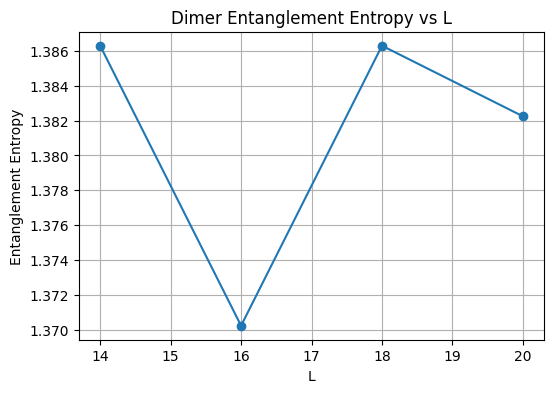

In [24]:
plt.figure(figsize=(6,4))
plt.plot(Ltar, dimer_ee_tar, marker='o')
#plt.xscale('log')
#plt.plot(Ltar, np.log(np.pi*np.asarray(Ltar)), linestyle='--', color='gray', label='log(L)')
plt.xlabel('L')
plt.ylabel('Entanglement Entropy')
plt.title('Dimer Entanglement Entropy vs L')
plt.grid(True)
plt.show()

In [25]:
def spin_operators():
    """Returns Sx, Sy, Sz for spin-1/2 as sparse matrices."""
    Sx = csr_matrix([[0, 1], [1, 0]], dtype=complex) / 2
    Sy = csr_matrix([[0, -1j], [1j, 0]], dtype=complex) / 2
    Sz = csr_matrix([[1, 0], [0, -1]], dtype=complex) / 2
    return Sx, Sy, Sz

def operator_on_sites(op_list, L, sites):
    """
    Places operators from op_list on the specified sites in a chain of length L.
    op_list: list of 2x2 sparse matrices (length = len(sites))
    sites: list of site indices (0-based)
    Returns: sparse matrix of size 2^L x 2^L
    """
    ops = []
    site_set = set(sites)
    idx = 0
    for i in range(L):
        if i in site_set:
            ops.append(op_list[idx])
            idx += 1
        else:
            ops.append(identity(2, format='csr'))
    result = ops[0]
    for op in ops[1:]:
        result = kron(result, op, format='csr')
    return result

def HMG(L):
    """Constructs the Majumdar-Ghosh Hamiltonian as a sparse matrix."""
    Sx, Sy, Sz = spin_operators()
    H = csr_matrix((2**L, 2**L), dtype=complex)
    for j in range(L):
        # Periodic boundary conditions
        j1 = j
        j2 = (j + 1) % L
        j3 = (j + 2) % L
        # (Sj + Sj+1 + Sj+2)^2
        Sx_sum = operator_on_sites([Sx, Sx, Sx], L, [j1, j2, j3])
        Sy_sum = operator_on_sites([Sy, Sy, Sy], L, [j1, j2, j3])
        Sz_sum = operator_on_sites([Sz, Sz, Sz], L, [j1, j2, j3])
        S_sum = Sx_sum + Sy_sum + Sz_sum
        S_sum_sq = S_sum @ S_sum
        H += S_sum_sq - (3/4) * identity(2**L, format='csr')
    return H

def CSC(L):
    """Constructs the chiral spin interaction term as a sparse matrix."""
    Sx, Sy, Sz = spin_operators()
    H = csr_matrix((2**L, 2**L), dtype=complex)
    for j in range(L):
        j1 = j
        j2 = (j + 1) % L
        j3 = (j + 2) % L
        # Sj · (Sj+1 × Sj+2)
        # = Sxj (Syj+1 Szj+2 - Szj+1 Syj+2)
        # + Syj (Szj+1 Sxj+2 - Sxj+1 Szj+2)
        # + Szj (Sxj+1 Syj+2 - Syj+1 Sxj+2)
        term1 = operator_on_sites([Sx, Sy, Sz], L, [j1, j2, j3])
        term2 = operator_on_sites([Sx, Sz, Sy], L, [j1, j2, j3])
        term3 = operator_on_sites([Sy, Sz, Sx], L, [j1, j2, j3])
        term4 = operator_on_sites([Sy, Sx, Sz], L, [j1, j2, j3])
        term5 = operator_on_sites([Sz, Sx, Sy], L, [j1, j2, j3])
        term6 = operator_on_sites([Sz, Sy, Sx], L, [j1, j2, j3])
        H += term1 - term2 + term3 - term4 + term5 - term6
    return H

def H_total(L, t):
    """Returns the full Hamiltonian H(t) = HMG + t * CSC as a sparse CSR matrix."""
    return HMG(L) + t * CSC(L)

In [26]:
t = 1.0  # Chiral interaction strength

H_mg = HMG(L)
H_cs = CSC(L)
H = H_total(L, t)

dimer_sparse = csr_matrix(dimer_state.reshape(-1, 1))

# MG term

# Apply the transverse field operator to the sparse vector
vec_mg = H_mg @ dimer_sparse
vec_mg = vec_mg.toarray()  # Convert to dense array for further processing

# Print information about the result
print(f"Shape of result - mg term: {vec_mg.shape}")
print(f"Number of nonzero elements in result: {np.count_nonzero(vec_mg)}")
print(f"Max absolute value in result: {np.max(np.abs(vec_mg.data))}")

# CSC term
vec_cs = H_cs @ dimer_sparse
vec_cs = vec_cs.toarray()  # Convert to dense array for further processing

# Print information about the result
print(f"Shape of result - csc term: {vec_cs.shape}")
print(f"Number of nonzero elements in result: {np.count_nonzero(vec_cs)}")
print(f"Max absolute value in result: {np.max(np.abs(vec_cs.data))}")

Shape of result - mg term: (262144, 1)
Number of nonzero elements in result: 1020
Max absolute value in result: 0.39628255920232086
Shape of result - csc term: (262144, 1)
Number of nonzero elements in result: 0
Max absolute value in result: 0.0


In [28]:
# Apply H_mg to dimer_sparse
vec_mg = H_mg @ dimer_sparse

# Flatten both vectors for comparison
dimer_vec = dimer_sparse.toarray().flatten()
vec_mg_flat = vec_mg.toarray().flatten()

# Compute the proportionality constant (eigenvalue candidate)
if np.linalg.norm(dimer_vec) > 0:
    ratio = vec_mg_flat / dimer_vec
    # Only consider nonzero components to avoid division by zero
    mask = np.abs(dimer_vec) > 1e-12
    eigenvalue_estimate = np.mean(ratio[mask])
    # Check if proportional within tolerance
    is_eigenvector = np.allclose(vec_mg_flat, eigenvalue_estimate * dimer_vec, atol=1e-10)
    print(f"Estimated eigenvalue: {eigenvalue_estimate}")
    print(f"Is dimer_sparse an eigenvector of H_mg? {is_eigenvector}")
else:
    print("dimer_sparse is zero vector, cannot check eigenvector property.")

Estimated eigenvalue: (-12.656250000000002+0j)
Is dimer_sparse an eigenvector of H_mg? True


C:\Users\camipolv\AppData\Local\Temp\ipykernel_14280\3214215043.py:10: RuntimeWarning: invalid value encountered in divide
  ratio = vec_mg_flat / dimer_vec
